# <font color='CC3D3D'> 0.5_7 Log_Feature_Merge
    
- 위에서 만든 duration.csv, visit.csv, event_cnt.csv, loan_apply_cnt.csv로부터 개별 유저에 관한 로그 데이터 집계 정보를 모두 취합한 데이터 생성
- 취합 데이터 <span style="color:blue"> **loan_with_new_feats.csv** </span> 생성

# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from IPython.display import display
import gc
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

with open("../Data/dtypes.pkl", 'rb') as f:
    dtypes = pickle.load(f)

In [ ]:
def viewinfo(df:pd.DataFrame) -> None:
    print(df.shape)
    print()
    df.info()
    print()
    display(df.head())

# Data Load

In [ ]:
loan = pd.read_csv("../Data/2022빅콘테스트_데이터분석리그_데이터분석분야_퓨처스부문_데이터셋_220908/loan_result.csv", engine='c',
                   low_memory=True,
                   parse_dates=['loanapply_insert_time'],
                   dtype={'application_id': 'uint32', 'bank_id': 'uint8', 'product_id': 'uint8'},
                   usecols=['application_id', 'loanapply_insert_time', 'is_applied'])

user = pd.read_csv(f"../Data/2022빅콘테스트_데이터분석리그_데이터분석분야_퓨처스부문_데이터셋_220908/user_spec.csv", engine='c',
                   dtype={'application_id': 'uint32', 'user_id': 'uint32'},
                   low_memory=True,
                   parse_dates=['insert_time'],
                   usecols=['application_id', 'user_id', 'insert_time'])

viewinfo(loan)
print()
viewinfo(user)

(13527363, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13527363 entries, 0 to 13527362
Data columns (total 3 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   application_id         uint32        
 1   loanapply_insert_time  datetime64[ns]
 2   is_applied             float64       
dtypes: datetime64[ns](1), float64(1), uint32(1)
memory usage: 258.0 MB



,application_id,loanapply_insert_time,is_applied
0,1748340,2022-06-07 13:05:41,NaN
1,1748340,2022-06-07 13:05:41,NaN
2,1748340,2022-06-07 13:05:41,NaN
3,1748340,2022-06-07 13:05:41,NaN
4,1748340,2022-06-07 13:05:41,NaN



(1394216, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394216 entries, 0 to 1394215
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   application_id  1394216 non-null  uint32        
 1   user_id         1394216 non-null  uint32        
 2   insert_time     1394216 non-null  datetime64[ns]
dtypes: datetime64[ns](1), uint32(2)
memory usage: 21.3 MB



,application_id,user_id,insert_time
0,1249046,118218,2022-06-07 06:28:18
1,954900,553686,2022-06-07 14:29:03
2,137274,59516,2022-06-07 21:40:22
3,1570936,167320,2022-06-07 09:40:27
4,967833,33400,2022-06-07 08:55:07


In [ ]:
app_user = {user['application_id'].iloc[i]: user['user_id'].iloc[i] for i in range(user.shape[0])}
loan['user_id'] = loan['application_id'].map(app_user)
loan.dropna(subset=['user_id'], inplace=True)
loan['user_id'] = loan['user_id'].astype(np.uint32)
loan['date_cd'] = pd.to_datetime(loan['loanapply_insert_time'].dt.date)
loan.sort_values(by=['user_id', 'loanapply_insert_time'], inplace=True)
loan.reset_index(drop=True, inplace=True)

In [ ]:
viewinfo(loan)

(13527250, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13527250 entries, 0 to 13527249
Data columns (total 5 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   application_id         uint32        
 1   loanapply_insert_time  datetime64[ns]
 2   is_applied             float64       
 3   user_id                uint32        
 4   date_cd                datetime64[ns]
dtypes: datetime64[ns](2), float64(1), uint32(2)
memory usage: 412.8 MB



,application_id,loanapply_insert_time,is_applied,user_id,date_cd
0,248576,2022-05-21 23:41:09,0.0,9,2022-05-21
1,248576,2022-05-21 23:41:09,0.0,9,2022-05-21
2,248576,2022-05-21 23:41:09,0.0,9,2022-05-21
3,248576,2022-05-21 23:41:09,0.0,9,2022-05-21
4,248576,2022-05-21 23:41:10,0.0,9,2022-05-21


In [ ]:
del user
gc.collect()

22

# Duration

In [ ]:
duration = pd.read_csv("../Data/duration.csv", engine='c',
                       low_memory=True, parse_dates=['date_cd'])
viewinfo(duration)

(1863305, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863305 entries, 0 to 1863304
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int64         
 1   date_cd   datetime64[ns]
 2   duration  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 42.6 MB



,user_id,date_cd,duration
0,9,2022-05-21,354
1,11,2022-03-24,347
2,11,2022-04-20,685
3,11,2022-06-09,169
4,11,2022-06-13,141


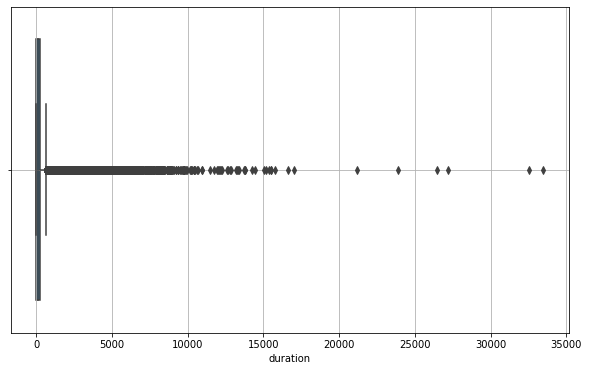

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=duration, x='duration')
plt.grid(True)
plt.show()

In [ ]:
duration[duration['duration'] == duration['duration'].max()]

,user_id,date_cd,duration
792305,374546,2022-04-06,33479


In [ ]:
loan[(loan['user_id'] == 374546)]['date_cd'].unique()

array(['2022-03-31T00:00:00.000000000', '2022-04-12T00:00:00.000000000',
       '2022-04-13T00:00:00.000000000', '2022-04-18T00:00:00.000000000',
       '2022-04-21T00:00:00.000000000', '2022-04-22T00:00:00.000000000',
       '2022-04-25T00:00:00.000000000', '2022-04-27T00:00:00.000000000',
       '2022-04-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
loan_duration = pd.merge(left=loan, right=duration, how='left', on=['user_id', 'date_cd'])
viewinfo(loan_duration)

(13527250, 8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13527250 entries, 0 to 13527249
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   application_id         uint32        
 1   loanapply_insert_time  datetime64[ns]
 2   is_applied             float64       
 3   user_id                uint32        
 4   date_cd                datetime64[ns]
 5   event                  float64       
 6   loan_cnt               float64       
 7   duration               float64       
dtypes: datetime64[ns](2), float64(4), uint32(2)
memory usage: 825.6 MB



,application_id,loanapply_insert_time,is_applied,user_id,date_cd,event,loan_cnt,duration
0,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
1,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
2,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
3,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
4,248576,2022-05-21 23:41:10,0.0,9,2022-05-21,3.0,0.0,354.0


In [ ]:
loan_duration[(loan_duration['user_id'] == 374546)]['date_cd'].unique()

array(['2022-03-31T00:00:00.000000000', '2022-04-12T00:00:00.000000000',
       '2022-04-13T00:00:00.000000000', '2022-04-18T00:00:00.000000000',
       '2022-04-21T00:00:00.000000000', '2022-04-22T00:00:00.000000000',
       '2022-04-25T00:00:00.000000000', '2022-04-27T00:00:00.000000000',
       '2022-04-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
loan_duration.isnull().sum()

application_id                 0
loanapply_insert_time          0
is_applied               3257239
user_id                        0
date_cd                        0
event                     703483
loan_cnt                  703483
duration                  991813
dtype: int64

In [ ]:
loan = loan_duration.copy()
del loan_duration, duration
gc.collect()

195

In [ ]:
## 유저별 평균
avg_duration = loan[['user_id', 'is_applied', 'duration']].groupby(by=['user_id', 'is_applied']).mean()
avg_duration.reset_index(drop=False, inplace=True)
viewinfo(avg_duration)

(417988, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417988 entries, 0 to 417987
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     417988 non-null  uint64 
 1   is_applied  417988 non-null  float64
 2   duration    378037 non-null  float64
dtypes: float64(2), uint64(1)
memory usage: 9.6 MB



,user_id,is_applied,duration
0,9,0.0,354.000000
1,11,0.0,519.595745
2,11,1.0,459.666667
3,14,0.0,NaN
4,17,0.0,1037.666667


In [ ]:
nulls = loan[(loan['duration'].isna())]
viewinfo(nulls)

(991813, 8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991813 entries, 155 to 13527249
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   application_id         991813 non-null  uint32        
 1   loanapply_insert_time  991813 non-null  datetime64[ns]
 2   is_applied             820693 non-null  float64       
 3   user_id                991813 non-null  uint32        
 4   date_cd                991813 non-null  datetime64[ns]
 5   event                  288330 non-null  float64       
 6   loan_cnt               288330 non-null  float64       
 7   duration               0 non-null       float64       
dtypes: datetime64[ns](2), float64(4), uint32(2)
memory usage: 60.5 MB



,application_id,loanapply_insert_time,is_applied,user_id,date_cd,event,loan_cnt,duration
155,1508745,2022-04-18 14:37:10,0.0,14,2022-04-18,NaN,NaN,NaN
156,1508745,2022-04-18 14:37:11,0.0,14,2022-04-18,NaN,NaN,NaN
162,1854180,2022-05-06 17:10:55,0.0,19,2022-05-06,NaN,NaN,NaN
163,513514,2022-03-13 20:17:19,1.0,20,2022-03-13,10.50,5.5,NaN
164,513514,2022-03-13 20:17:19,0.0,20,2022-03-13,9.68,5.1,NaN


In [ ]:
viewinfo(loan)

(13527250, 8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13527250 entries, 0 to 13527249
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   application_id         uint32        
 1   loanapply_insert_time  datetime64[ns]
 2   is_applied             float64       
 3   user_id                uint32        
 4   date_cd                datetime64[ns]
 5   event                  float64       
 6   loan_cnt               float64       
 7   duration               float64       
dtypes: datetime64[ns](2), float64(4), uint32(2)
memory usage: 825.6 MB



,application_id,loanapply_insert_time,is_applied,user_id,date_cd,event,loan_cnt,duration
0,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
1,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
2,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
3,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
4,248576,2022-05-21 23:41:10,0.0,9,2022-05-21,3.0,0.0,354.0


In [ ]:
for idx in tqdm(nulls.index):
    _, _, is_applied, user_id, _, _, _, _ = nulls.loc[idx]
    sub = avg_duration[(avg_duration['user_id'] == user_id) & (avg_duration['is_applied'] == is_applied)]
    if sub.shape[0] == 0:
        continue
    loan['duration'].loc[idx] = sub['duration'].values[0]

100%|██████████| 991813/991813 [43:36<00:00, 379.10it/s]


In [ ]:
viewinfo(loan)

(13527250, 8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13527250 entries, 0 to 13527249
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   application_id         uint32        
 1   loanapply_insert_time  datetime64[ns]
 2   is_applied             float64       
 3   user_id                uint32        
 4   date_cd                datetime64[ns]
 5   event                  float64       
 6   loan_cnt               float64       
 7   duration               float64       
dtypes: datetime64[ns](2), float64(4), uint32(2)
memory usage: 825.6 MB



,application_id,loanapply_insert_time,is_applied,user_id,date_cd,event,loan_cnt,duration
0,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
1,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
2,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
3,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0
4,248576,2022-05-21 23:41:10,0.0,9,2022-05-21,3.0,0.0,354.0


In [ ]:
loan.isnull().sum()

application_id                 0
loanapply_insert_time          0
is_applied               3257239
user_id                        0
date_cd                        0
event                     703483
loan_cnt                  703483
duration                  703483
dtype: int64

# Visits

In [ ]:
visit = pd.read_csv("../Data/visit.csv", engine='c', low_memory=True, parse_dates=['date_cd'],
                    dtype={'user_id':'uint32', 'visit':'uint8'})
viewinfo(visit)

(1863305, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863305 entries, 0 to 1863304
Data columns (total 3 columns):
 #   Column   Dtype         
---  ------   -----         
 0   user_id  uint32        
 1   date_cd  datetime64[ns]
 2   visit    uint8         
dtypes: datetime64[ns](1), uint32(1), uint8(1)
memory usage: 23.1 MB



,user_id,date_cd,visit
0,9,2022-05-21,1
1,11,2022-03-24,1
2,11,2022-04-20,1
3,11,2022-06-09,1
4,11,2022-06-13,1


In [ ]:
visit['visit'].max()

17

In [ ]:
loan_visit = pd.merge(left=loan, right=visit, how='left', on=['user_id', 'date_cd'])
viewinfo(loan_visit)

(13527250, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13527250 entries, 0 to 13527249
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   application_id         uint32        
 1   loanapply_insert_time  datetime64[ns]
 2   is_applied             float64       
 3   user_id                uint32        
 4   date_cd                datetime64[ns]
 5   event                  float64       
 6   loan_cnt               float64       
 7   duration               float64       
 8   visit_x                float64       
 9   visit_y                float64       
dtypes: datetime64[ns](2), float64(6), uint32(2)
memory usage: 1.0 GB



,application_id,loanapply_insert_time,is_applied,user_id,date_cd,event,loan_cnt,duration,visit_x,visit_y
0,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0,1.0,1.0
1,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0,1.0,1.0
2,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0,1.0,1.0
3,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0,1.0,1.0
4,248576,2022-05-21 23:41:10,0.0,9,2022-05-21,3.0,0.0,354.0,1.0,1.0


In [ ]:
loan = loan_visit.copy()
del loan_visit
gc.collect()

22

In [ ]:
loan.drop(['visit_y'], axis=1, inplace=True)
columns = list(loan.columns.values)
columns[-1] = 'visit'
columns

['application_id',
 'loanapply_insert_time',
 'is_applied',
 'user_id',
 'date_cd',
 'event',
 'loan_cnt',
 'duration',
 'visit']

In [ ]:
loan.columns = columns

In [ ]:
## 유저별 평균
avg_visit = loan[['user_id', 'is_applied', 'visit']].groupby(by=['user_id', 'is_applied']).mean()
avg_visit.reset_index(drop=False, inplace=True)
viewinfo(avg_visit)

(417988, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417988 entries, 0 to 417987
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     417988 non-null  uint64 
 1   is_applied  417988 non-null  float64
 2   visit       378037 non-null  float64
dtypes: float64(2), uint64(1)
memory usage: 9.6 MB



,user_id,is_applied,visit
0,9,0.0,1.000000
1,11,0.0,1.000000
2,11,1.0,1.000000
3,14,0.0,NaN
4,17,0.0,1.666667


In [ ]:
for idx in tqdm(nulls.index):
    tup = nulls.loc[idx]
    is_applied, user_id = tup[2], tup[3]
    sub = avg_visit[(avg_visit['user_id'] == user_id) & (avg_visit['is_applied'] == is_applied)]
    if sub.shape[0] == 0:
        continue
    loan['visit'].loc[idx] = sub['visit'].values[0]

100%|██████████| 991813/991813 [43:51<00:00, 376.94it/s]


In [ ]:
viewinfo(loan)

(13527250, 9)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13527250 entries, 0 to 13527249
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   application_id         uint32        
 1   loanapply_insert_time  datetime64[ns]
 2   is_applied             float64       
 3   user_id                uint32        
 4   date_cd                datetime64[ns]
 5   event                  float64       
 6   loan_cnt               float64       
 7   duration               float64       
 8   visit                  float64       
dtypes: datetime64[ns](2), float64(5), uint32(2)
memory usage: 928.8 MB



,application_id,loanapply_insert_time,is_applied,user_id,date_cd,event,loan_cnt,duration,visit
0,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0,1.0
1,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0,1.0
2,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0,1.0
3,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0,354.0,1.0
4,248576,2022-05-21 23:41:10,0.0,9,2022-05-21,3.0,0.0,354.0,1.0


In [ ]:
loan.isnull().sum()

application_id                 0
loanapply_insert_time          0
is_applied               3257239
user_id                        0
date_cd                        0
event                     703483
loan_cnt                  703483
duration                  703483
visit                     703483
dtype: int64

# Event Count

In [ ]:
app_event = pd.read_csv("../Data/event_cnt.csv", engine='c', 
                        low_memory=True, parse_dates=['date_cd'])
loan_apply_count = pd.read_csv("../Data/loan_apply_cnt.csv", 
                               engine='c', low_memory=True, parse_dates=['date_cd'])

viewinfo(app_event)
print()
viewinfo(loan_apply_count)

(1863305, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863305 entries, 0 to 1863304
Data columns (total 3 columns):
 #   Column   Dtype         
---  ------   -----         
 0   user_id  int64         
 1   date_cd  datetime64[ns]
 2   event    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 42.6 MB



,user_id,date_cd,event
0,9,2022-05-21,3
1,11,2022-03-24,12
2,11,2022-04-20,21
3,11,2022-06-09,5
4,11,2022-06-13,5



(1863305, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863305 entries, 0 to 1863304
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int64         
 1   date_cd   datetime64[ns]
 2   loan_cnt  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 42.6 MB



,user_id,date_cd,loan_cnt
0,9,2022-05-21,0
1,11,2022-03-24,3
2,11,2022-04-20,7
3,11,2022-06-09,3
4,11,2022-06-13,3


In [ ]:
print(app_event['event'].max())
print(loan_apply_count['loan_cnt'].max())

305
152


In [ ]:
for i, (event, loan_cnt) in enumerate(zip(app_event['event'], loan_apply_count['loan_cnt'])):
    if event < loan_cnt:
        print(app_event.iloc[i])
print("None")

None


In [ ]:
cnt_merge = pd.merge(left=app_event, right=loan_apply_count, on=['user_id', 'date_cd'], how='left')
# cnt_merge.fillna(0)
viewinfo(cnt_merge)

(1863305, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863305 entries, 0 to 1863304
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int64         
 1   date_cd   datetime64[ns]
 2   event     int64         
 3   loan_cnt  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 71.1 MB



,user_id,date_cd,event,loan_cnt
0,9,2022-05-21,3,0
1,11,2022-03-24,12,3
2,11,2022-04-20,21,7
3,11,2022-06-09,5,3
4,11,2022-06-13,5,3


In [ ]:
del app_event, loan_apply_count
gc.collect()

88

In [ ]:
loan_cnt_merge = pd.merge(left=loan, right=cnt_merge, on=['user_id', 'date_cd'], how='left')
viewinfo(loan_cnt_merge)

(13527250, 7)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13527250 entries, 0 to 13527249
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   application_id         uint32        
 1   loanapply_insert_time  datetime64[ns]
 2   is_applied             float64       
 3   user_id                uint32        
 4   date_cd                datetime64[ns]
 5   event                  float64       
 6   loan_cnt               float64       
dtypes: datetime64[ns](2), float64(3), uint32(2)
memory usage: 722.4 MB



,application_id,loanapply_insert_time,is_applied,user_id,date_cd,event,loan_cnt
0,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0
1,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0
2,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0
3,248576,2022-05-21 23:41:09,0.0,9,2022-05-21,3.0,0.0
4,248576,2022-05-21 23:41:10,0.0,9,2022-05-21,3.0,0.0


In [ ]:
del loan
gc.collect()

44

In [ ]:
loan_cnt_merge.isnull().sum()

application_id                 0
loanapply_insert_time          0
is_applied               3257239
user_id                        0
date_cd                        0
event                     991813
loan_cnt                  991813
dtype: int64

In [ ]:
loan = loan_cnt_merge.copy()
del loan_cnt_merge
gc.collect()

44

In [ ]:
## 유저별 평균
avg_events = loan[['user_id', 'is_applied', 'event', 'loan_cnt']].groupby(by=['user_id', 'is_applied']).mean()
avg_events.reset_index(drop=False, inplace=True)
viewinfo(avg_events)

(417988, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417988 entries, 0 to 417987
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     417988 non-null  uint64 
 1   is_applied  417988 non-null  float64
 2   event       378037 non-null  float64
 3   loan_cnt    378037 non-null  float64
dtypes: float64(3), uint64(1)
memory usage: 12.8 MB



,user_id,is_applied,event,loan_cnt
0,9,0.0,3.000000,0.000000
1,11,0.0,16.595745,5.042553
2,11,1.0,15.000000,4.333333
3,14,0.0,NaN,NaN
4,17,0.0,12.000000,7.000000


In [ ]:
nulls = loan[(loan['event'].isna()) | (loan['loan_cnt'].isna())]
viewinfo(nulls)

(991813, 7)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991813 entries, 155 to 13527249
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   application_id         991813 non-null  uint32        
 1   loanapply_insert_time  991813 non-null  datetime64[ns]
 2   is_applied             820693 non-null  float64       
 3   user_id                991813 non-null  uint32        
 4   date_cd                991813 non-null  datetime64[ns]
 5   event                  0 non-null       float64       
 6   loan_cnt               0 non-null       float64       
dtypes: datetime64[ns](2), float64(3), uint32(2)
memory usage: 53.0 MB



,application_id,loanapply_insert_time,is_applied,user_id,date_cd,event,loan_cnt
155,1508745,2022-04-18 14:37:10,0.0,14,2022-04-18,NaN,NaN
156,1508745,2022-04-18 14:37:11,0.0,14,2022-04-18,NaN,NaN
162,1854180,2022-05-06 17:10:55,0.0,19,2022-05-06,NaN,NaN
163,513514,2022-03-13 20:17:19,1.0,20,2022-03-13,NaN,NaN
164,513514,2022-03-13 20:17:19,0.0,20,2022-03-13,NaN,NaN


In [ ]:
for idx in tqdm(nulls.index):
    _, _, is_applied, user_id, _, _, _ = nulls.loc[idx]
    sub = avg_events[(avg_events['user_id'] == user_id) & (avg_events['is_applied'] == is_applied)]
    # print(user_id, is_applied)
    # display(sub)
    if sub.shape[0] == 0:
        continue
    loan['event'].loc[idx] = sub['event'].values[0]
    loan['loan_cnt'].loc[idx] = sub['loan_cnt'].values[0]

100%|██████████| 991813/991813 [46:17<00:00, 357.06it/s]


In [ ]:
loan.iloc[163]

application_id                        513514
loanapply_insert_time    2022-03-13 20:17:19
is_applied                               1.0
user_id                                   20
date_cd                  2022-03-13 00:00:00
event                                   10.5
loan_cnt                                 5.5
Name: 163, dtype: object

## Deployment CSV

In [ ]:
loan.to_csv("../Data/loan_with_new_feats.csv", index=False)

# Application path

In [ ]:
app_path =  pd.read_csv("../Data/path_applied_user.csv", engine='c', low_memory=True)
noapp_path =  pd.read_csv("../Data/path_no_applied_user.csv", engine='c', low_memory=True)

viewinfo(app_path)
print()
viewinfo(noapp_path)

(354998, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354998 entries, 0 to 354997
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   application_id  354998 non-null  int64 
 1   path            354998 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.4+ MB



,application_id,path
0,14,"('GetCreditInfo', 'GetCreditInfo')"
1,17,"('OpenApp', 'ViewLoanApplyIntro', 'CompleteIDC..."
2,28,"('OpenApp', 'StartLoanApply', 'ViewLoanApplyIn..."
3,34,"('OpenApp', 'StartLoanApply', 'ViewLoanApplyIn..."
4,36,"('OpenApp', 'Login', 'GetCreditInfo', 'StartLo..."



(323291, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323291 entries, 0 to 323290
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   application_id  323291 non-null  int64 
 1   path            323291 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.9+ MB



,application_id,path
0,1,"('OpenApp', 'StartLoanApply', 'ViewLoanApplyIn..."
1,2,"('OpenApp', 'Login', 'StartLoanApply', 'ViewLo..."
2,6,"('OpenApp', 'Login', 'UseLoanManage', 'GetCred..."
3,20,"('OpenApp', 'Login', 'GetCreditInfo', 'UseLoan..."
4,26,"('OpenApp', 'Login', 'GetCreditInfo', 'StartLo..."


In [ ]:
paths = pd.concat([app_path, noapp_path], axis=0)
paths.reset_index(drop=True)
viewinfo(paths)

(678289, 2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678289 entries, 0 to 323290
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   application_id  678289 non-null  int64 
 1   path            678289 non-null  object
dtypes: int64(1), object(1)
memory usage: 15.5+ MB



,application_id,path
0,14,"('GetCreditInfo', 'GetCreditInfo')"
1,17,"('OpenApp', 'ViewLoanApplyIntro', 'CompleteIDC..."
2,28,"('OpenApp', 'StartLoanApply', 'ViewLoanApplyIn..."
3,34,"('OpenApp', 'StartLoanApply', 'ViewLoanApplyIn..."
4,36,"('OpenApp', 'Login', 'GetCreditInfo', 'StartLo..."


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(paths['path'])
paths['path_group'] = le.transform(paths['path'])

paths.head()

,application_id,path,path_group
0,14,"('GetCreditInfo', 'GetCreditInfo')",4541
1,17,"('OpenApp', 'ViewLoanApplyIntro', 'CompleteIDC...",157300
2,28,"('OpenApp', 'StartLoanApply', 'ViewLoanApplyIn...",143686
3,34,"('OpenApp', 'StartLoanApply', 'ViewLoanApplyIn...",141689
4,36,"('OpenApp', 'Login', 'GetCreditInfo', 'StartLo...",53296


In [ ]:
paths['path_group'].nunique()

171812